## Employee Attrition Project

##### Business Problem

“In order to build a rewarding employee experience, you need to understand what matters most to your people.” – 
Julie Bevacqua
  Among all employee related problems, employee attrition is one of the key problems in today’s scenario despite the changes in the external environment. In simplicity, attrition is the gradual reduction in number of employees through resignation, death and retirement.
  Attrition is the silent killer that can swiftly disable even the most successful and stable of organizations in a shockingly spare amount of time. While many companies put an emphasis on the expensive process of hiring and recruiting, there is not enough attention towards solving the issues that cause top talent to leave.

##### The Solution Methodology

In this section, we have used four algorithms to predict employee attrition. With an impetus to accurately predict the attrition in employees and the reasons/factors responsible for the attrition we hereby provide: a). Logistic Regression b). Random Forest  c). Naive Bayes d). Linear Support Vector Machine

a). Logistic regression is a process of modeling the probability of a discrete outcome given an input variable. The most common logistic regression models a binary outcome; something that can take two values such as true/false, yes/no, and so on.

b). Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time.

c). Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables.

d). A Linear support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks.

##### 1. Load the Employee Attrition DATA

In [0]:
#Load the file

file_location = "/FileStore/tables/Employee_Attrition.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

emp_df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

emp_df.count()

Out[18]: 1470

##### 2. Explore the data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np 

In [0]:
# 2.1 Null Check
pandaDf = emp_df.toPandas()

pandaDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int32 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int32 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int32 
 6   Education                 1470 non-null   int32 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int32 
 9   EmployeeNumber            1470 non-null   int32 
 10  EnvironmentSatisfaction   1470 non-null   int32 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int32 
 13  JobInvolvement            1470 non-null   int32 
 14  JobLevel                

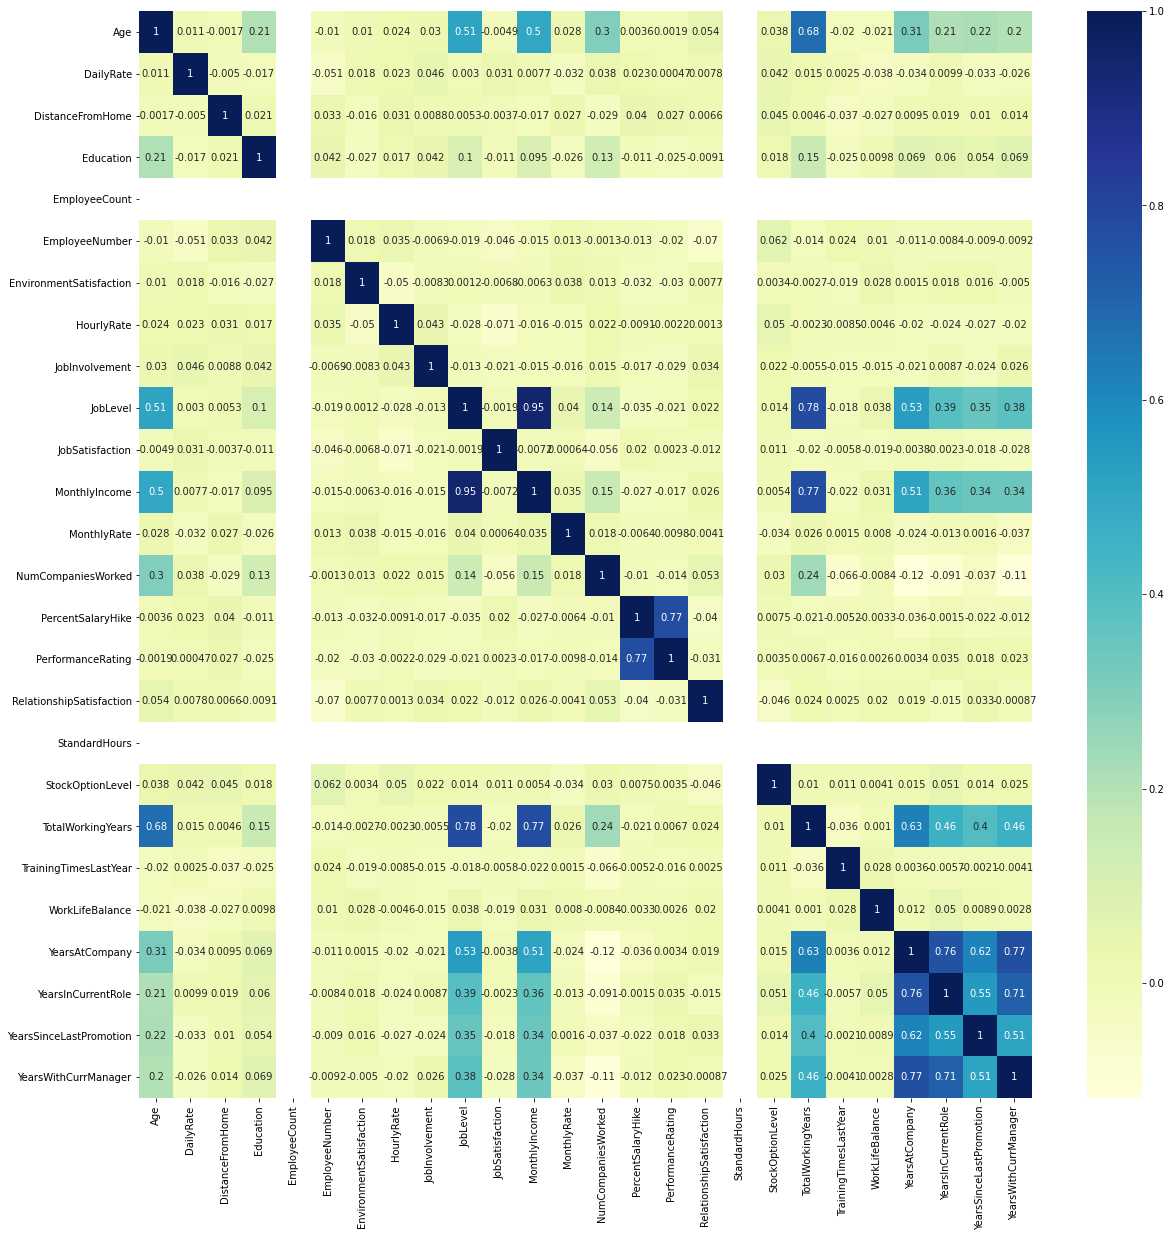

In [0]:
# 2.2 Collinearity Check - Heat Map

plt.figure(figsize = (20,20))
sns.heatmap(pandaDf.corr(),cmap="YlGnBu", annot=True);

##### Collinearity Check Conclusion:
```
 We observed EmployeeCount and Standard hours has only one value and it does not have any impact on other variables. 
 Hence, we will be removing it from our further analysis
```

###### 2.3 Finding if any correlation exists between dependent variable(Attrition) and those independent variables which show collinearity with other independent variables like Years at company, Years in Current role, Years Since Last Promotion and Years with Current Manager

##### 3. Pre-processing the dataset
```
1. String to Categorical features
2. One Hot encoder to convert the discrete variables into binary vectors
3. Vector Assembler
4. Standard Scaling
5. Split the dataset - Train and Test
```

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler,StringIndexer,OneHotEncoder,StandardScaler
from pyspark.ml import Pipeline

In [0]:
# 1. Use StringIndexer - to convert the categorical columns to hold numerical data
 
BusinessTravel_indexer = StringIndexer(inputCol='BusinessTravel',outputCol='BusinessTravel_index',handleInvalid='keep')
Department_indexer = StringIndexer(inputCol='Department',outputCol='Department_index',handleInvalid='keep')
EducationField_indexer = StringIndexer(inputCol='EducationField',outputCol='EducationField_index',handleInvalid='keep')
Gender_indexer = StringIndexer(inputCol='Gender',outputCol='Gender_index',handleInvalid='keep')
JobRole_indexer = StringIndexer(inputCol='JobRole',outputCol='JobRole_index',handleInvalid='keep')
MaritalStatus_indexer = StringIndexer(inputCol='MaritalStatus',outputCol='MaritalStatus_index',handleInvalid='keep')
Over18_indexer = StringIndexer(inputCol='Over18',outputCol='Over18_index',handleInvalid='keep')
OverTime_indexer = StringIndexer(inputCol='OverTime',outputCol='OverTime_index',handleInvalid='keep')
Attrition_indexer = StringIndexer(inputCol='Attrition',outputCol='Attrition_index',handleInvalid='skip')


# 2. OneHotEncoderEstimator - to convert the newly indexed data into a vector which will be effectively handled by our respective models.
# We will not be using One Hot Encoder for "Attrition_Index" as we will need it as a column of integers for prediction rather that a binary vector column

data_encoder = OneHotEncoder(inputCols=['BusinessTravel_index','Department_index','EducationField_index','Gender_index','JobRole_index', 'MaritalStatus_index','Over18_index','OverTime_index'], 
                             outputCols= ['BusinessTravel_ohe','Department_ohe','EducationField_ohe','Gender_ohe','JobRole_ohe', 'MaritalStatus_ohe','Over18_ohe','OverTime_ohe'],handleInvalid='keep')

# 3. Vector assembler - to create a vector of input features
  # Assigning a variable and inputing all attribute names required for input of vector assembler
  # Removing Employee Count and Standard Hours as per our Collinearity Check analysis

assemblerInputs = ['Age','BusinessTravel_ohe','Department_ohe','EducationField_ohe','Gender_ohe','JobRole_ohe', 'MaritalStatus_ohe','Over18_ohe','OverTime_ohe','DailyRate','DistanceFromHome','Education', 
                 'EnvironmentSatisfaction','HourlyRate','JobInvolvement','JobLevel', 'JobSatisfaction','MonthlyIncome','MonthlyRate','NumCompaniesWorked','PercentSalaryHike','PerformanceRating',
                 'RelationshipSatisfaction','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear','WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
 
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="unscaled_features")

# 4. Standard scaler - to scale the data so that Our respective models can perform well on the training data

scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

#5. Splitting the entire dataset into Train and Test dataset
 
train_data,test_data = emp_df.randomSplit([0.75,0.25])

#6. Pipeline
# Combining all our trasnformers as a single pipeline so that the data can be processed through these transformers one after the other

pipeline = Pipeline(stages=[BusinessTravel_indexer,Department_indexer,EducationField_indexer,Gender_indexer,
                        JobRole_indexer,MaritalStatus_indexer,Over18_indexer,
                        OverTime_indexer,Attrition_indexer,data_encoder,assembler,scaler])

pipelineModel = pipeline.fit(train_data)

final_train_data = pipelineModel.transform(train_data)
final_test_data = pipelineModel.transform(test_data)

##### 4. Models Creation and Hyper Parameter Tuning 
```
  - Tuning Logistic Regression, Random Forest, Linear SVM, and Naive Bayes to find the best accuracy
  - Using ParameterGrid to pass set of parameters
  - Running Cross Validation on each set of parameter and keeping the set with higher accuracy
```

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [0]:
# Model's instance

lr_model = LogisticRegression(labelCol='Attrition_index')
randomforest = RandomForestClassifier(labelCol='Attrition_index', featuresCol="features")
lsvc = LinearSVC(labelCol='Attrition_index', featuresCol="features")
nb = NaiveBayes(labelCol='Attrition_index')

In [0]:
# ParameterGrid Builder

paramGrid = (ParamGridBuilder()\
      .addGrid(lr_model.regParam, [0.1, 0.01])\
      #.addGrid(lr_model.elasticNetParam, [0.0, 0.5, 1.0])\
      .addGrid(lsvc.threshold, [0.2, 0.12]) \
      #.addGrid(lsvc.maxIter, [5,10,15]) \
      #.addGrid(lsvc.regParam, [0.1, 0.2, 0.3, 0.4, 0.5]) \
      .addGrid(nb.smoothing, list(range(1,15,2))) \
      .addGrid(randomforest.numTrees, [10,20,30])\
      #.addGrid(randomforest.maxDepth, [5,10])\
      .build())

In [0]:
# Running cross validaor to find best set of parameters

crossval_lr = CrossValidator(estimator=lr_model,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator().setLabelCol("Attrition_index"),
                          numFolds=2) 

crossval_rf = CrossValidator(estimator=randomforest,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator().setLabelCol("Attrition_index"),
                          numFolds=2) 

crossval_nb = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator().setLabelCol("Attrition_index"),
                          numFolds=2) 

crossval_lsvc = CrossValidator(estimator=lsvc,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator().setLabelCol("Attrition_index"),
                          numFolds=2) 

In [0]:
# Fitting the model onto the training dataset

cvModel_lr = crossval_lr.fit(final_train_data)
cvModel_rf = crossval_rf.fit(final_train_data)
cvModel_nb = crossval_nb.fit(final_train_data)
cvModel_lsvc = crossval_lsvc.fit(final_train_data)

##### 5. Model Saving And Loading

```
Since, the model creation process is time-consuming, we have saved the model for modularity.
```

In [0]:
# Saving the model in DBFS for later use

cvModel_lr.save('lr_model')
cvModel_rf.save('rf_model')
cvModel_nb.save('nb_model')
cvModel_lsvc.save('lsvc_model')

In [0]:
# Accessing the model from DBFS

lr = CrossValidatorModel.load('dbfs:/lr_model/')
rf = CrossValidatorModel.load('dbfs:/rf_model/')
nb = CrossValidatorModel.load('dbfs:/nb_model/')
lsvc = CrossValidatorModel.load('dbfs:/lsvc_model/')

##### 6. Predicting the probability of the employees leaving the organization.

In [0]:
pred_lr = lr.transform(final_test_data)
pred_rf = rf.transform(final_test_data)
pred_nb = nb.transform(final_test_data)
pred_lsvc = lsvc.transform(final_test_data)

In [0]:
pred_lr.select('Attrition_index', 'prediction', 'probability').show(50)

+---------------+----------+--------------------+
|Attrition_index|prediction|         probability|
+---------------+----------+--------------------+
|            1.0|       0.0|[0.81498802563022...|
|            0.0|       0.0|[0.62127491209876...|
|            1.0|       1.0|[0.12317708853439...|
|            1.0|       1.0|[0.15023446841486...|
|            0.0|       0.0|[0.70821470016294...|
|            0.0|       0.0|[0.89356264338897...|
|            1.0|       1.0|[0.37524279795891...|
|            1.0|       0.0|[0.66213194468069...|
|            0.0|       0.0|[0.77788344720277...|
|            1.0|       1.0|[0.18179914943615...|
|            0.0|       0.0|[0.58626169646635...|
|            0.0|       0.0|[0.88206781657052...|
|            0.0|       0.0|[0.83100650211741...|
|            0.0|       0.0|[0.93054432387214...|
|            0.0|       0.0|[0.97016455893133...|
|            1.0|       1.0|[0.48151666629288...|
|            1.0|       0.0|[0.70536413316203...|


In [0]:
pred_rf.select('Attrition_index', 'prediction', 'probability').show(50)

+---------------+----------+--------------------+
|Attrition_index|prediction|         probability|
+---------------+----------+--------------------+
|            1.0|       0.0|[0.71057391488872...|
|            0.0|       1.0|[0.44311858180411...|
|            1.0|       1.0|[0.38857808857808...|
|            1.0|       1.0|[0.24969696969696...|
|            0.0|       0.0|[0.66191088835686...|
|            0.0|       0.0|[0.51926956706263...|
|            1.0|       1.0|[0.48888197016341...|
|            1.0|       0.0|[0.78449099862507...|
|            0.0|       0.0|[0.78449099862507...|
|            1.0|       0.0|[0.84393513754862...|
|            0.0|       0.0|[0.57163498229590...|
|            0.0|       0.0|[0.89506269216454...|
|            0.0|       0.0|[0.57890289552960...|
|            0.0|       0.0|[0.77106070236228...|
|            0.0|       0.0|[0.88787453148801...|
|            1.0|       0.0|[0.60018631798949...|
|            1.0|       0.0|[0.61697820826976...|


In [0]:
pred_nb.select('Attrition_index', 'prediction', 'probability').show(50)

+---------------+----------+--------------------+
|Attrition_index|prediction|         probability|
+---------------+----------+--------------------+
|            1.0|       0.0|[0.89695111825004...|
|            0.0|       1.0|[0.08494817939265...|
|            1.0|       1.0|[9.88037738267618...|
|            1.0|       1.0|[1.17316685958113...|
|            0.0|       1.0|[3.51195107987616...|
|            0.0|       0.0|[0.67629576047631...|
|            1.0|       1.0|[0.00558019573194...|
|            1.0|       1.0|[0.00340147731596...|
|            0.0|       1.0|[0.04977711346543...|
|            1.0|       1.0|[0.06851917835566...|
|            0.0|       0.0|[0.96292748651411...|
|            0.0|       0.0|[0.95922786739651...|
|            0.0|       1.0|[0.30138925250375...|
|            0.0|       0.0|[0.99916987827666...|
|            0.0|       0.0|[0.96574846327883...|
|            1.0|       1.0|[0.07607932712242...|
|            1.0|       1.0|[0.19745854000956...|


In [0]:
#pred_lsvc.select('Attrition_index', 'prediction', 'probability').show(50)

##### 7. Evaulating the models

In [0]:
# Compute accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="Attrition_index", predictionCol="prediction", metricName="accuracy")

predictions_train_lr = cvModel_lr.transform(final_train_data)
predictions_train_rf = cvModel_rf.transform(final_train_data)
predictions_train_nb = cvModel_nb.transform(final_train_data)
predictions_train_lsvc = cvModel_lsvc.transform(final_train_data)

##### Train vs Test Accuracy

In [0]:

print("Train vs Test Accuracy")
print("--"*40)

nbaccuracy = evaluator.evaluate(pred_lr)
print("Logistic Regression - Test set accuracy = " + str(nbaccuracy))

nbaccuracy = evaluator.evaluate(predictions_train_lr)
print("Logistic Regression - Train set accuracy = " + str(nbaccuracy))

print("--"*40)

nbaccuracy = evaluator.evaluate(pred_rf)
print("Random Forest - Test set accuracy = " + str(nbaccuracy))

nbaccuracy = evaluator.evaluate(predictions_train_rf)
print("Random Forest - Train set accuracy = " + str(nbaccuracy))

print("--"*40)

nbaccuracy = evaluator.evaluate(pred_nb)
print("Naive Bayes - Test set accuracy = " + str(nbaccuracy))
nbaccuracy = evaluator.evaluate(predictions_train_nb)
print("Naive Bayes - Train set accuracy = " + str(nbaccuracy))

print("--"*40)

nbaccuracy = evaluator.evaluate(pred_lsvc)
print("SVM Classifier - Test set accuracy = " + str(nbaccuracy))

nbaccuracy = evaluator.evaluate(predictions_train_lsvc)
print("SVM Classifier - Train set accuracy = " + str(nbaccuracy))


Train vs Test Accuracy
--------------------------------------------------------------------------------
Logistic Regression - Test set accuracy = 0.8971428571428571
Logistic Regression - Train set accuracy = 0.8875
--------------------------------------------------------------------------------
Random Forest - Test set accuracy = 0.8685714285714285
Random Forest - Train set accuracy = 0.8580357142857142
--------------------------------------------------------------------------------
Naive Bayes - Test set accuracy = 0.7742857142857142
Naive Bayes - Train set accuracy = 0.8125
--------------------------------------------------------------------------------
SVM Classifier - Test set accuracy = 0.8971428571428571
SVM Classifier - Train set accuracy = 0.8866071428571428


##### 8. Based on the training and the testing accuracy, we have concluded that the Best model is Logistic Regression over the other models.

In [0]:
# For the BEST model

AUC_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Attrition_index',metricName='areaUnderROC')
AUC = AUC_evaluator.evaluate(pred_lr)
print("The area under the curve is {}".format(AUC))

PR_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Attrition_index',metricName='areaUnderPR')
PR = PR_evaluator.evaluate(pred_lr)
print("The area under the PR curve is {}".format(PR))

The area under the curve is 0.6958489081251229
The area under the PR curve is 0.59187675070028


In [0]:
from sklearn.metrics import confusion_matrix

y_true = pred_lr.select("Attrition_index")
y_true = y_true.toPandas()

y_pred = pred_lr.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
print("Below is the confusion matrix: \n {}".format(cnf_matrix))

Below is the confusion matrix: 
 [[293   6]
 [ 30  21]]


##### 9. Conclusion:
```
Based on our analysis,  we can say that with 89% confidence that the model is able to explain the dataset very well. 

However, the dataset seems to be biased towards the people leaving their job as compared to staying with their current organization. 
Out of the total 1700 sample, 1400 employees are saitisfied with their job, and does not think of leaving their job, while only 237 employees completed the attrition process. 
So, we believe that if we would have a more balanced data with employee from both categories, we could have generalized and enriched our model to be used for future prediction purposes.

```

##### 10. Future Scope:
```
  a. More data can be fetched from social platforms like Linkedin or glassdoor to get the current organization of the employee.
  b. The models can be further generalized by taking geographical locations and preferences in to account
```

##### 11. References:
```
  a. Dataset: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset
  b. PySpark Documentation: https://spark.apache.org/docs/latest/api/python/reference/index.html
                            https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html
                            https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html
                            https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.OneHotEncoder.html?highlight=sparse
                            https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StandardScaler.html
                            https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html
  c. https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27                          
  d. https://www.youtube.com/watch?v=_cTQ81slI4M
  Kindly note, most of our codes have been referred from and modified based on code examples taught in class and present on canvas
```